In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import tensorflow as tf
import tensorflow_probability as tfp

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.diagnostics import true_vs_estimated

from meta_aux_classes import *

In [2]:
class GaussianPrior:
    def __init__(self, D, mu_mean=0, mu_scale=1):
        self.D = D
        self.mu_mean = mu_mean
        self.mu_scale = mu_scale
    
    def __call__(self, n_sim):
        theta = np.random.default_rng().normal(self.mu_mean, self.mu_scale, size=(n_sim, self.D))
        return theta

class GaussianSimulator:
    def __init__(self):
        pass
    
    def __call__(self, theta, n_obs):
        n_sim, D = theta.shape
        
        tril = tf.linalg.cholesky(np.stack([np.eye(D)] * n_sim))   # fancy way to get unit variance
        
        mvn = tfp.distributions.MultivariateNormalTriL(loc=theta, scale_tril=tril)

        x = mvn.sample(n_obs)
        x = np.array(x)
        x = np.transpose(x, (1, 0, 2))
        return x
    
prior = GaussianPrior(D=3)
simulator = GaussianSimulator()

In [3]:
D = 5 

#########

prior = GaussianPrior(D)
simulator = GaussianSimulator()
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=D*2,  # one mean and variance per dim
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork({'n_params': D})

amortizer = SingleModelAmortizer(inference_net, summary_net)

In [4]:
trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      learning_rate=0.0001,
                      checkpoint_path='ckpt/'
                     )

Initializing networks from scratch.


In [ ]:
losses = trainer.train_online(epochs=1, iterations_per_epoch=100, batch_size=512, n_obs=100)

In [9]:
losses = trainer.train_rounds(epochs=10, rounds=5, sim_per_round=20000, batch_size=512, n_obs=100)

Simulating initial 20000 data sets...
Converting 20000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/40 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/40 [00:00<?, ?it/s]

Simulating new 20000 data sets and appending to previous...
New total number of simulated data sets: 40000
Converting 40000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Simulating new 20000 data sets and appending to previous...
New total number of simulated data sets: 60000
Converting 60000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/118 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/118 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/118 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/118 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/118 [00:00<?, ?it/s]

Simulating new 20000 data sets and appending to previous...
New total number of simulated data sets: 80000
Converting 80000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Simulating new 20000 data sets and appending to previous...
New total number of simulated data sets: 100000
Converting 100000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/196 [00:00<?, ?it/s]

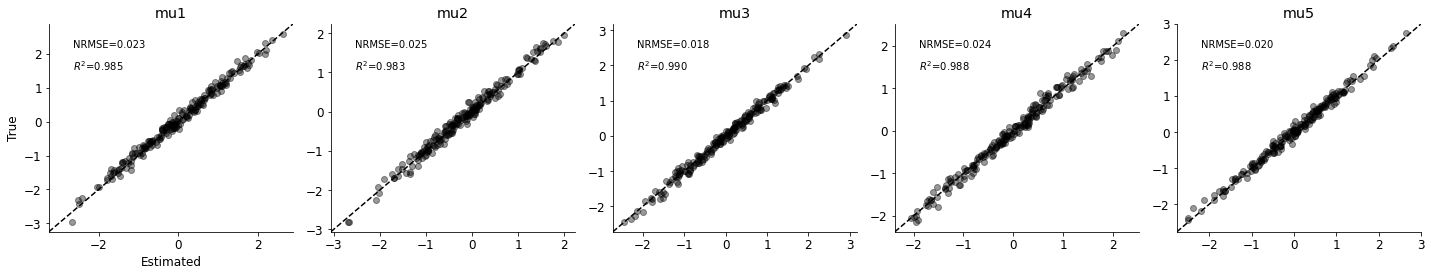

In [17]:
# Validate (quick and dirty)
p, x = trainer._forward_inference(200, 100)
param_samples = trainer.network.sample(x, n_samples=200)
param_means = param_samples.mean(axis=0)
true_vs_estimated(p, param_means, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))

In [12]:
trainer.network.summary_net(x).shape

TensorShape([200, 10])

In [14]:
trainer.manager.save()

'ckpt/ckpt-101'